In [1]:
print(1)


1


In [ ]:
import ir_datasets
import email
import pandas as pd
import matplotlib.pyplot as plt
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, GenerationConfig
import gc
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from config import *
import re
import numpy as np
import json
import os

In [3]:
import sys
sys.path.append("../scripts/")

In [4]:
from dataset import load_sara
from eval import jupyter_evaluation
from model import llm_experiment, post_process_split_docs
from models import get_model_version
from preprocess_sara import proccutit


#s = load_sara()
#proc = proccutit(s)
#tokenizer, model = get_model_version('get_mistral', "mistralai/Mistral-7B-Instruct-v0.2", 'main', 'auto')
#jupyter_evaluation(labels, preds)
#llm_experiment(dataset, prompt_strategy, model, tokenizer, end_prompt=None):
#post_process_split_docs(mr, fpr, pre, df)

## Reading results

In [5]:
#os.listdir('../scripts/results')

In [6]:
def get_results_json(file_name):
    current_directory = os.getcwd()
    parent_directory = os.path.dirname(current_directory)
    target_directory = os.path.join(parent_directory, 'scripts/results')
    #print("Path to results", target_directory)

    #file_name = 'test.json'
    file_path = os.path.join(target_directory, file_name)
    #print(file_path)

    with open(file_path) as json_file:
        data = json.load(json_file)

    df = pd.DataFrame(data)
    #print(df)
    return df

In [7]:
all_results_df = get_results_json('clean_model_responses.json')

In [8]:
results_df = all_results_df[(all_results_df['prompt'] == 'itspersonal') | (all_results_df['prompt'] == 'itspersonal_2') | (all_results_df['prompt'] == 'itspersonalfewshot') | (all_results_df['prompt'] == 'itspersonalsys') | (all_results_df['prompt'] == 'itspersonal_2sys') | (all_results_df['prompt'] == 'itspersonalfewshotsys')]

In [9]:
results_df

,model,prompt,doc_id,prediction,ground_truth
0,mixt-4bit,itspersonal,114715,0,0
1,mixt-4bit,itspersonal,229405,0,0
2,mixt-4bit,itspersonal,232795,0,0
3,mixt-4bit,itspersonal,62815,0,0
4,mixt-4bit,itspersonal,118871,0,0
...,...,...,...,...,...
49535,mist7b-mist,itspersonalfewshotsys,232322,0,0
49536,mist7b-mist,itspersonalfewshotsys,175448,0,0
49537,mist7b-mist,itspersonalfewshotsys,175814,1,0
49538,mist7b-mist,itspersonalfewshotsys,175816,1,0


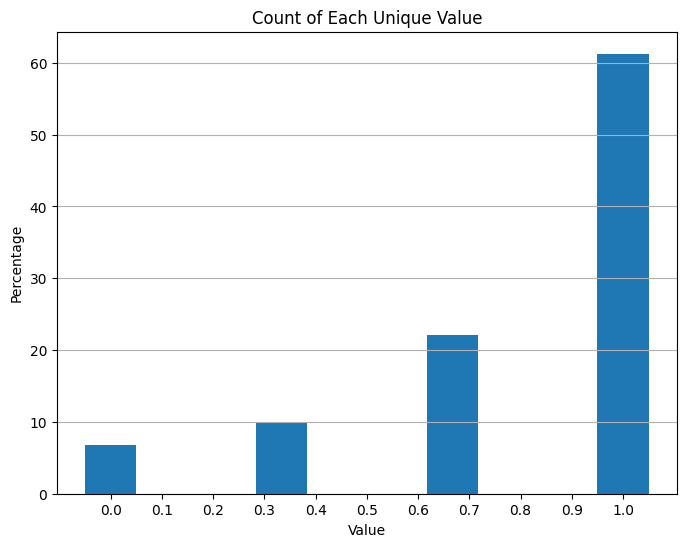

In [10]:
def got_correct(df, prompt):
    doc_percentage_correct = {}

    for d in df.doc_id.unique():
        doc_preds = df[df.doc_id == d]
        doc_preds = doc_preds[doc_preds.prompt == prompt]
        #print(doc_preds)

        # For sensitive docs
        #doc_preds = doc_preds[doc_preds.ground_truth == 0]
        #if len(doc_preds) == 0:
        #    continue

        doc_correct = 0
        for s in doc_preds.iterrows():
            row = s[1]
            if row.prediction == row.ground_truth:
                doc_correct += 1

        doc_correct_avg = doc_correct / len(doc_preds)
        doc_percentage_correct[d] = doc_correct_avg

    return doc_percentage_correct

def plot_correct(data):
    unique_values, counts = np.unique(data, return_counts=True)
    total_count = len(data)
    percentages = (counts / total_count) * 100

    # Bar plot
    plt.figure(figsize=(8, 6))
    plt.bar(unique_values, percentages, width=0.1)
    plt.xlabel('Value')
    plt.ylabel('Percentage')
    plt.title('Count of Each Unique Value')
    plt.xticks(np.arange(0, 1.1, 0.1))  # Set x-ticks to show the range 0.0 - 1.0
    plt.grid(axis='y')
    plt.show()


prompt = 'itspersonal'
doc_percentage_correct = got_correct(results_df, prompt)
plot_correct(list(doc_percentage_correct.values()))

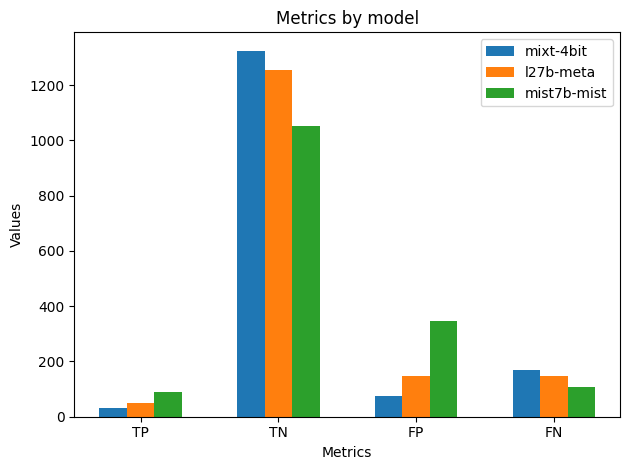

In [11]:
def confusion_scores(df, prompt):
    doc_percentage_correct = {}

    for d in df.model.unique():

        doc_preds = df[df.model == d]
        doc_preds = doc_preds[doc_preds.prompt == prompt]
        TP, TN, FP, FN = 0, 0, 0, 0

        for s in doc_preds.iterrows():
            row = s[1]
            if row.prediction == row.ground_truth and row.ground_truth == 1:
                TP += 1
            elif row.prediction == row.ground_truth and row.ground_truth == 0:
                TN += 1
            elif row.prediction != row.ground_truth and row.ground_truth == 1:
                FN += 1
            else:
                FP += 1

        scores = [TP, TN, FP, FN]
        doc_percentage_correct[d] = scores

    return doc_percentage_correct

def plot_confusion(data):
    data = model_confusion
    labels = ['TP', 'TN', 'FP', 'FN']
    models = list(data.keys())
    values = np.array(list(data.values()))

    # Number of groups and bar width
    n_groups = len(labels)
    bar_width = 0.2

    # Set position of bar on X axis
    r = np.arange(len(labels))
    positions = [r + bar_width*i for i in range(len(models))]

    # Make bars
    for pos, model in zip(positions, models):
        plt.bar(pos, values[models.index(model)], width=bar_width, label=model)

    plt.xlabel('Metrics')
    plt.ylabel('Values')
    plt.title('Metrics by model')
    plt.xticks([r + bar_width for r in range(n_groups)], labels)
    plt.legend()
    plt.tight_layout()
    plt.show()


prompt = 'itspersonal'
model_confusion = confusion_scores(results_df, prompt)
plot_confusion(model_confusion)

In [12]:
results_df.keys()

Index(['model', 'prompt', 'doc_id', 'prediction', 'ground_truth'], dtype='object')

In [13]:
results_df

,model,prompt,doc_id,prediction,ground_truth
0,mixt-4bit,itspersonal,114715,0,0
1,mixt-4bit,itspersonal,229405,0,0
2,mixt-4bit,itspersonal,232795,0,0
3,mixt-4bit,itspersonal,62815,0,0
4,mixt-4bit,itspersonal,118871,0,0
...,...,...,...,...,...
49535,mist7b-mist,itspersonalfewshotsys,232322,0,0
49536,mist7b-mist,itspersonalfewshotsys,175448,0,0
49537,mist7b-mist,itspersonalfewshotsys,175814,1,0
49538,mist7b-mist,itspersonalfewshotsys,175816,1,0


#### Prompt Effectiveness

Prompt performance: How models perform across different prompts

In [14]:
from sklearn.metrics import balanced_accuracy_score, f1_score

def calculate_accuracy(group):
    correct_predictions = (group['prediction'] == group['ground_truth']).sum()
    total_predictions = len(group)
    accuracy = correct_predictions / total_predictions
    return accuracy

def calculate_balanced_accuracy(group):
    return balanced_accuracy_score(group['ground_truth'], group['prediction'])

def calculate_f1(group):
    return f1_score(group['ground_truth'], group['prediction'], average='weighted')

def prompt_performance(df):
    #accuracy_df = results_df.groupby(['model', 'prompt']).apply(lambda x: (x['prediction'] == x['ground_truth']).mean()).reset_index(name='accuracy')
    # Group by model and prompt, then apply the calculation for each metric
    grouped = df.groupby(['model', 'prompt'])
    accuracy_df = grouped.apply(calculate_accuracy).reset_index(name='accuracy')
    balanced_accuracy_df = grouped.apply(calculate_balanced_accuracy).reset_index(name='balanced_accuracy')
    f1_score_df = grouped.apply(calculate_f1).reset_index(name='f1_score')
    # Merge results into a single DataFrame - easy comparison
    performance_df = pd.merge(accuracy_df, balanced_accuracy_df, on=['model', 'prompt'])
    performance_df = pd.merge(performance_df, f1_score_df, on=['model', 'prompt'])
    #print(performance_df)
    return performance_df

prompt_performance_df = prompt_performance(results_df)

In [45]:
prompt_performance_df

,model,prompt,accuracy,balanced_accuracy,f1_score
0,l27b-meta,itspersonal,0.815394,0.571595,0.814788
1,l27b-meta,itspersonal_2,0.827910,0.539711,0.814621
2,l27b-meta,itspersonal_2sys,0.836045,0.522673,0.813844
3,l27b-meta,itspersonalfewshot,0.175219,0.509773,0.133915
4,l27b-meta,itspersonalfewshotsys,0.158323,0.500130,0.103313
5,l27b-meta,itspersonalsys,0.806008,0.533716,0.802008
6,mist7b-mist,itspersonal,0.715717,0.601445,0.755702
7,mist7b-mist,itspersonal_2,0.661240,0.571245,0.715561
8,mist7b-mist,itspersonal_2sys,0.618034,0.555326,0.682469
9,mist7b-mist,itspersonalfewshot,0.429912,0.564069,0.505461


In [17]:
prev_results_df = all_results_df[(all_results_df['prompt'] == 'b1') | (all_results_df['prompt'] == 'b2') | (all_results_df['prompt'] == 'b1_2') | (all_results_df['prompt'] == 'b2_2') | (all_results_df['prompt'] == 'b1sys') | (all_results_df['prompt'] == 'b2sys') | (all_results_df['prompt'] == 'b1_2sys') | (all_results_df['prompt'] == 'b2_2sys')]
prompt_performance(prev_results_df)

,model,prompt,accuracy,balanced_accuracy,f1_score
0,l27b-meta,b1,0.782690,0.488259,0.776632
1,l27b-meta,b1_2,0.759700,0.485606,0.768147
2,l27b-meta,b1_2sys,0.692115,0.468716,0.727621
3,l27b-meta,b1sys,0.759700,0.474766,0.765976
4,l27b-meta,b2,0.645585,0.433642,0.695250
5,l27b-meta,b2_2,0.559800,0.432694,0.634359
6,l27b-meta,b2_2sys,0.418910,0.433031,0.506877
7,l27b-meta,b2sys,0.604258,0.440604,0.667776
8,mist7b-mist,b1,0.831258,0.503696,0.801917
9,mist7b-mist,b1_2,0.871715,0.504004,0.819451


Interaction effects: we aim to assess interaction effects between models and prompts. An ANOVA (Analysis of Variance) if data meets the is parametric.

#### Incomplete interaction effects

In [12]:
l2_mist = prompt_performance_df
l2_mist = l2_mist.drop([6, 7])
l2_mist

,model,prompt,accuracy,balanced_accuracy
0,l27b-meta,itspersonal,0.782854,0.557359
1,l27b-meta,itspersonal_2,0.799750,0.517136
2,l27b-meta,itspersonalfewshot,0.178348,0.513727
3,mist7b-mist,itspersonal,0.694969,0.592748
4,mist7b-mist,itspersonal_2,0.655542,0.579719
5,mist7b-mist,itspersonalfewshot,0.419900,0.554019


In [13]:
import statsmodels.api as sm
import statsmodels.formula.api as smf


l2_mist['model'] = l2_mist['model'].astype(str)
l2_mist['prompt'] = l2_mist['prompt'].astype(str)
# Model with interaction between 'model' and 'prompt'
model = smf.ols('accuracy ~ model * prompt', data=l2_mist).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               accuracy   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 28 Feb 2024   Prob (F-statistic):                nan
Time:                        13:54:59   Log-Likelihood:                 203.58
No. Observations:                   6   AIC:                            -395.2
Df Residuals:                       0   BIC:                            -396.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

/scratch/2469038g/miniconda3/envs/ryanenv2/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/scratch/2469038g/miniconda3/envs/ryanenv2/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/scratch/2469038g/miniconda3/envs/ryanenv2/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/scratch/2469038g/miniconda3/envs/ryanenv2/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


In [14]:
from scipy.stats import kruskal

data1 = l2_mist[l2_mist['model'] == 'l27b-meta']['accuracy']
data2 = l2_mist[l2_mist['model'] == 'mist7b-mist']['accuracy']
#data3 = results_df[results_df['model'] == 'mixt4bit']['accuracy']

# Kruskal-Wallis H Test
stat, p = kruskal(data1, data2) #, data3)
print('Statistics=%.3f, p=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')


Statistics=0.429, p=0.513
Same distributions (fail to reject H0)


#### Document Difficulty

Identify difficult documents to classify. We calculate the misclassification rate for each document across all models and prompts.

We find documents that no model-prompt combination could predict this correctly.

In [18]:
def get_most_difficult_docs(df):
    misclassification_df = df.groupby('doc_id').apply(lambda x: (x['prediction'] != x['ground_truth']).mean()).reset_index(name='misclassification_rate')
    # Sorting finds the documents with the highest misclassification rates
    return misclassification_df.sort_values(by='misclassification_rate', ascending=False)

def get_all_wrong():
    # Documents entirely misclassified
    return most_difficult_docs[most_difficult_docs.misclassification_rate == 1]

most_difficult_docs = get_most_difficult_docs(results_df)
all_wrong = get_all_wrong()


Next, we analyse these errors. We will manually review the documents, their predicted and ground truths.

In [19]:
def get_n_most_difficult_docs(most_difficult_docs, n=10):
    difficult_doc_ids = most_difficult_docs['doc_id'].head(n)
    return difficult_doc_ids

difficult_doc_ids = get_n_most_difficult_docs(most_difficult_docs)

In [20]:
s = load_sara()
diff_id = list(difficult_doc_ids)

id_index = []
for idd in diff_id:
    find = s[s.doc_id == idd]
    id_index.append(find.index[0])

print(id_index)
x = proccutit(s.loc[id_index])
for hard in x.iterrows():
    print(hard[1].text)
    break

[229, 203, 900, 1299, 1176, 1026, 1438, 1394, 893, 1563]
Attached is a brief note on liquidity with references to a couple of surveys which provide further information.  My attempt was to write at a reasonable degree of simplicity while providing a general familiarity with the attendant issues.  Please comment.  Thanks.
Also, Profs. Maureen O'Hara, Lawrence Glosten, Haim Mendelson, Joel Hasbrouck, Hans Stoll, Albert Kyle, Lawerence Harris, and Ananth Madhavan are some of the leading academics in the field.
Rakesh


#### Model Comparison Analysis

We conduct numerous statistical tests.

In [21]:
### Do models vary given different prompts.
### Do prompts vary when used by different models.
### Inter-model agreement



In [22]:
model = 'l27b-meta'
model_results_df = results_df[results_df['model'] == model]

In [23]:
model_results_df

,model,prompt,doc_id,prediction,ground_truth
30369,l27b-meta,itspersonal,114715,0,0
30370,l27b-meta,itspersonal,229405,0,0
30371,l27b-meta,itspersonal,232795,0,0
30372,l27b-meta,itspersonal,62815,0,0
30373,l27b-meta,itspersonal,118871,0,0
...,...,...,...,...,...
39952,l27b-meta,itspersonalfewshotsys,232322,1,0
39953,l27b-meta,itspersonalfewshotsys,175448,1,0
39954,l27b-meta,itspersonalfewshotsys,175814,1,0
39955,l27b-meta,itspersonalfewshotsys,175816,1,0


In [24]:
x = prompt_performance(model_results_df)

In [25]:
x

,model,prompt,accuracy,balanced_accuracy,f1_score
0,l27b-meta,itspersonal,0.815394,0.571595,0.814788
1,l27b-meta,itspersonal_2,0.827910,0.539711,0.814621
2,l27b-meta,itspersonal_2sys,0.836045,0.522673,0.813844
3,l27b-meta,itspersonalfewshot,0.175219,0.509773,0.133915
4,l27b-meta,itspersonalfewshotsys,0.158323,0.500130,0.103313
5,l27b-meta,itspersonalsys,0.806008,0.533716,0.802008
